In [1]:
!git clone https://github.com/Zenodia/VehiclePlatesDetection.git

Cloning into 'VehiclePlatesDetection'...
remote: Enumerating objects: 65, done.
remote: Total 65 (delta 0), reused 0 (delta 0), pack-reused 65
Unpacking objects: 100% (65/65), done.


In [2]:
!ls

sample_data  VehiclePlatesDetection


In [3]:
cd VehiclePlatesDetection/

/content/VehiclePlatesDetection


In [4]:
!ls

data  Swedish_licence_plate_bbox_detection.ipynb


In [0]:
image_folder = 'data/images/'
annot_folder = 'data/annot/'


In [6]:
from __future__ import absolute_import, division, print_function
import numpy as np
import argparse
import random
import os
from scipy import misc
from skimage import draw
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

def create_model(image_height, image_width, loss, optimizer):
    """Creates the cat face locator model.
    Args:
        image_height: The height of the input images.
        image_width: The width of the input images.
        loss: Keras loss function (name or object), e.g. "mse".
        optimizer: Keras optimizer to use, e.g. Adam() or "sgd".
    Returns:
        Sequential
    """

    model = Sequential()

    # 3x128x128
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(image_height, image_width,3)))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Dropout(0.0))

    # 32x128x128
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 64x64x64
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x32x32
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 128x16x16
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # 256x8x8 = 16384
    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.5))

    model.add(Dense(4))
    model.add(Activation("linear"))

    # compile with mean squared error
    print("Compiling...")
    model.compile(loss=loss, optimizer=optimizer)

    return model

Using TensorFlow backend.


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(40,40))


def NMS_debug(ith, train_imgs, show=False, cnt=0):
    y_class=[]
    y_coor=[]
    cnt=0

    #print(y_true.shape)
    image=cv2.imread(train_imgs[ith]['filename'])

    for obj in train_imgs[ith]['object']:
        #print(ith,obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
        b=(obj['xmin'],obj['ymin'],obj['xmax'],obj['ymax'])
        
        xmin_norm=b[0]/256.
        ymin_norm=b[1]/256.
        box_width=(b[2]-b[0])/256.
        box_height=(b[3]-b[1])/256.
        y_coor.append(np.array([xmin_norm,ymin_norm,box_width, box_height]))
             
                
    if show:
        _x=int(xmin_norm*256)
        _y=int(ymin_norm*256)
        _w=int(box_width*256)
        _h=int(box_height*256)
        cv2.rectangle(image,(_x,_y),(_x+_w,_y+_h),(0,0,255),4)
        plt.figure(figsize=(30,30))
        plt.imshow(image[:,:,[2,1,0]])
        plt.show()
    return  y_coor

<Figure size 2880x2880 with 0 Axes>

In [0]:
import os
import cv2
import copy
import numpy as np

import xml.etree.ElementTree as ET


def parse_annotation_v2(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) >= 1 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

imgs, labels = parse_annotation_v2(annot_folder,
                                                image_folder,
                                                'sv_licence_plate')




In [9]:
Y=[]
X=[]

cnt=0
flag=True
for i in range(len(imgs)):
    im=cv2.imread(imgs[i]['filename'])
    im=im/255
    #print(im.shape)
    X.append(im)
    if cnt>=3:
        flas=False
    y_coor=NMS_debug(i, imgs, False,cnt=cnt)
    Y.append(y_coor)
    cnt+=1
Y=np.array(Y)
Y=np.stack(Y, axis=0)
Y=Y.reshape(30,4)
X=np.array(X)


Y.shape, X.shape

((30, 4), (30, 256, 256, 3))

In [0]:
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)


        # boxTrue
        x_boxTrue_tleft = y_true[0,0]  # numpy index selection
        y_boxTrue_tleft = y_true[0,1]
        boxTrue_width = y_true[0,2]
        boxTrue_height = y_true[0,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[0,0]
        y_boxPred_tleft = y_pred[0,1]
        boxPred_width = y_pred[0,2]
        boxPred_height = y_pred[0,3]
        area_boxPred = (boxPred_width * boxPred_height)


        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = iou.astype(np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)

def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

In [17]:

# do not run unless you want to retrain
from keras.models import load_model
import tensorflow as tf
checkpoint = ModelCheckpoint('ckpoint_LicencePlate.h5', verbose=1, monitor='val_loss',save_best_only=True)
# Returns a compiled model identical to the previous one
m= create_model(256, 256, 'mse', 'Adam')
m.compile(optimizer='Adam', loss='mse', metrics=[IoU])









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Compiling...

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [18]:
# do not run unless you want to retrain
m.fit(X[:-8],Y[:-8],epochs=2000,batch_size=8,initial_epoch=1000,shuffle=True,callbacks=[checkpoint], validation_data=(X[-8:],Y[-8:]))




Train on 22 samples, validate on 8 samples
Epoch 1001/2000





22/22 [==============================] - 17s 780ms/step - loss: 9.9074 - IoU: 0.0049 - val_loss: 0.2572 - val_IoU: 0.0000e+00

Epoch 01001: val_loss improved from inf to 0.25721, saving model to ckpoint_LicencePlate.h5
Epoch 1002/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.9367 - IoU: 0.0000e+00 - val_loss: 0.7589 - val_IoU: 0.0000e+00

Epoch 01002: val_loss did not improve from 0.25721
Epoch 1003/2000
22/22 [==============================] - 0s 9ms/step - loss: 1.1711 - IoU: 0.0000e+00 - val_loss: 0.7047 - val_IoU: 0.0000e+00

Epoch 01003: val_loss did not improve from 0.25721
Epoch 1004/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.8014 - IoU: 0.0000e+00 - val_loss: 0.4357 - val_IoU: 0.0000e+00

Epoch 01004: val_loss did not improve from 0.25721
Epoch 1005/2000
22/22 [==============================] - 0s 9ms/step - loss: 0.6936 - IoU: 0.0000e+00 - val_loss: 0.4304 - val_Io

In [19]:
# serialize model to JSON
from keras.models import model_from_json
from keras.models import model_from_json
model_json = m.to_json()
with open("LicencePlate_IOU_Loss.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
m.save_weights("LicencePlate_IOU_Loss.h5")
print("Saved model to disk")
 
# later...

# load json and create model
json_file = open('LicencePlate_IOU_Loss.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("LicencePlate_IOU_Loss.h5")
loaded_model.compile(optimizer='Adam', loss='mse', metrics=[IoU])

Saved model to disk


0014.jpg
pred [0.2754945  0.45577547 0.14824983 0.04381816]
true [0.11328125 0.73046875 0.09765625 0.05078125]
true 29 187 25 13
pred 70 116 37 11


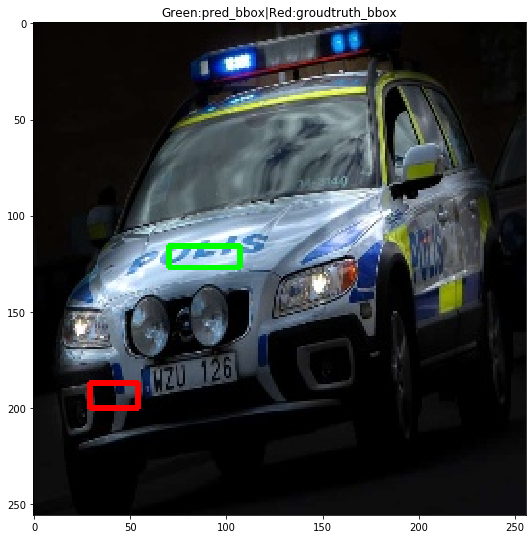

0018.jpg
pred [0.35529587 0.51750106 0.15328567 0.05707564]
true [0.1953125  0.37109375 0.1484375  0.10546875]
true 50 95 38 27
pred 90 132 39 14


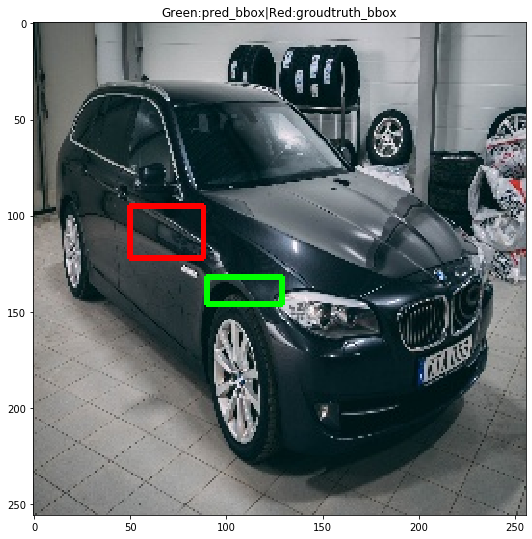

0002.jpg
pred [0.34495693 0.5341578  0.14866789 0.05659177]
true [0.21484375 0.6640625  0.20703125 0.09375   ]
true 55 170 53 24
pred 88 136 38 14


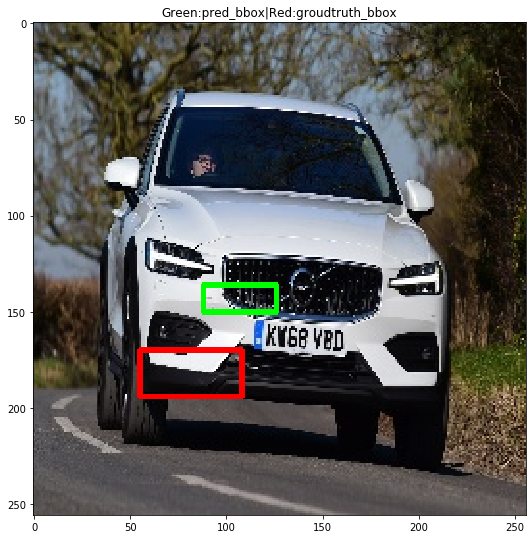

In [20]:
%matplotlib inline

import random
#model.save('licence_plat_bbox_se.h5')
val_ls=os.listdir(image_folder)
max_image_displayed=3
for i in range(max_image_displayed):
    plt.figure(figsize=(30,20))
    plt.subplot(1,max_image_displayed,i+1)
    rn=random.randint(0,len(val_ls)-1)
    print(val_ls[rn])
    im=cv2.imread(image_folder+val_ls[rn])
    ye = loaded_model.predict(im.reshape(1,256,256,3))
    x,y,w,h=[int(k) for k in ye[0]*256]
    print("pred",ye[0])
    tx,ty,tw,th=[int(k) for k in Y[rn]*256]
    print("true",Y[rn])
    print("true",tx,ty,tw,th)
    print("pred",x,y,w,h)
    cv2.rectangle(im, (tx,ty),(tx+tw,ty+th), (0,0,255),2)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)

    plt.imshow(im[:,:,[2,1,0]])
    plt.title("Green:pred_bbox|Red:groudtruth_bbox")
    plt.show()